In [3]:
import stream2 as st2
import pandas as pd
import scanpy as sc
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os

In [6]:
folder = '../../../singlecell-id-paper/data/Cytotrace_datasets/anndata/'
folder_out = '../../../singlecell-id-paper/results/Cytotrace_datasets/no_pooling/'

fnames = np.array([f for f in os.listdir(folder) if '.h5ad' in f])
sort_fnames = np.argsort(list(map(lambda fname : int(fname.split('_')[1].split('.')[0]),fnames)))
datasets = [d[:-5] for d in fnames[sort_fnames]]

selection = [2,5,8,13,23,24,25,26,35,38,39,40,41]
n=len(selection)

In [ ]:
f, axs = plt.subplots(n,3,figsize=(20,4*n))

for i, dataset in enumerate(np.array(datasets)[selection][-1:]):
    print(i,end='\r')
    adata = sc.read(folder_out+dataset+'.h5ad')
    
    #col, l = elpigraph_v2.labels_to_color(adata.uns['Order'], palette='viridis')
    #col2, l2 = elpigraph_v2.labels_to_color(adata.uns['Phenotype'], palette='hls')
    
    _=axs[i,0].scatter(*adata.uns['X_fa'].T,s=.5,c=-adata.uns['CytoTRACE']+adata.uns['CytoTRACE'].max())
    axs[i,1].scatter(*adata.uns['X_fa'].T,s=.5,c=col)
    axs[i,2].scatter(*adata.uns['X_fa'].T,s=.5,c=col2)
    
    f.colorbar(_,ax=axs[i,0])
    axs[i,0].set_ylabel(dataset)
    axs[i,1].legend(handles=l,bbox_to_anchor=(1,1))
    axs[i,2].legend(handles=l2,bbox_to_anchor=(1,1))
    
plt.tight_layout()
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 3664
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 30
Calculatng minimum spanning tree...
Number of initial branches: 14


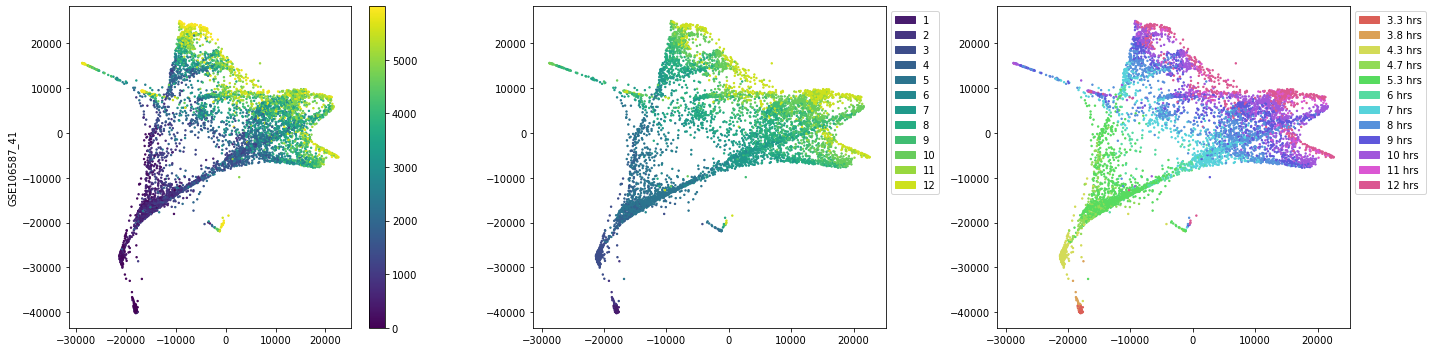

In [4]:
dataset=np.array(datasets)[selection][-1]
#---inputs
adata = sc.read(folder_out+dataset+'.h5ad')

nNodes = 100
alpha = 0.01
beta = 0
pseudotimeLambda = 0.001
nclusters = 30

roots     = []
pg_seed   = []
pg        = []
spg_fixed = []
spg_full  = []

X_elpi = adata.obsm['X_dr'] = adata.uns['X_fa']
pseudotime = -adata.uns['CytoTRACE']+adata.uns['CytoTRACE'].max()
root_NodePosition2, lowest_ps_idx2 = elpigraph_v2.make_root_node_v2(X_elpi, pseudotime, n_neighbors=15)
#dists_to_root = sklearn.metrics.pairwise_distances(root_NodePosition2[None],X_elpi)[0]
#TrimmingRadius = np.percentile(dists_to_root,33)

#---seed graph
st.seed_elastic_principal_graph(adata,n_clusters=nclusters,use_vis=False)
epg = adata.uns['seed_epg']
dict_nodes_pos = nx.get_node_attributes(epg,'pos')
init_nodes_pos = np.array(list(dict_nodes_pos.values()))
init_edges = np.array(list(epg.edges())) 
init_nodes_pos, init_edges = elpigraph_v2.seed_epg_supervised(X_elpi,pseudotime,pseudotime_weight=.2,n_clusters=30)
init_edges[-2]=[2,10]

#---store
roots.append(     [root_NodePosition2,lowest_ps_idx2] )
pg_seed.append(   dict(NodePositions=init_nodes_pos,Edges=[init_edges]) )
#pg.append(        elpigraph.computeElasticPrincipalTree(X_elpi, nNodes, Do_PCA=False, CenterData=False, StoreGraphEvolution=True, InitNodePositions=init_nodes_pos, InitEdges=init_edges,alpha=alpha,beta=beta)[0])
#spg_fixed.append( elpigraph.computeElasticPrincipalTree(X_elpi, nNodes, Do_PCA=False, CenterData=False, StoreGraphEvolution=True, InitNodePositions=init_nodes_pos, InitEdges=init_edges,alpha=alpha,beta=beta, FixNodesAtPoints=[lowest_ps_idx2])[0])
spg_full.append(  elpigraph.computeElasticPrincipalTree(X_elpi, nNodes, Do_PCA=False, CenterData=False, StoreGraphEvolution=True, InitNodePositions=init_nodes_pos, InitEdges=init_edges,alpha=alpha,beta=beta,
                                                        #new params
                                                        pseudotime=pseudotime,
                                                        pseudotimeLambda=pseudotimeLambda,
                                                        FixNodesAtPoints=[lowest_ps_idx2])[0])
#---plot
f,axs = plt.subplots(1,3,figsize=(20,5))
axs=axs.flat

col, l = elpigraph_v2.labels_to_color(adata.uns['Order'], palette='viridis')
col2, l2 = elpigraph_v2.labels_to_color(adata.uns['Phenotype'], palette='hls')

_=axs[0].scatter(*adata.uns['X_fa'].T,s=2,c=-adata.uns['CytoTRACE']+adata.uns['CytoTRACE'].max())
axs[1].scatter(*adata.uns['X_fa'].T,s=2,c=col)
axs[2].scatter(*adata.uns['X_fa'].T,s=2,c=col2)

f.colorbar(_,ax=axs[0])
axs[0].set_ylabel(dataset)
axs[1].legend(handles=l,bbox_to_anchor=(1,1))
axs[2].legend(handles=l2,bbox_to_anchor=(1,1))

plt.tight_layout()